## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [17]:
! pip install opencv-python
! pip install tqdm pandas numpy torch torchvision matplotlib

In [19]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import re
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [21]:
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    images = []
    labels = []

    if "test" in os.path.basename(set_dir).lower():
        raw_filenames = os.listdir(set_dir)
        valid_filenames = [f for f in raw_filenames if re.search(r'\d+', f)]
        filenames = sorted(valid_filenames, key=lambda x: int(re.findall(r'\d+', x)[0]))

        for fname in tqdm(filenames, desc="Loading test set"):
            path = os.path.join(set_dir, fname)
            img = cv2.imread(path)
            if img is not None:
                images.append(img)
        return images, labels

    # For train/val sets with subfolders
    class_dirs = sorted(os.listdir(set_dir))
    for class_name in class_dirs:
        class_path = os.path.join(set_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        filenames = sorted(os.listdir(class_path))
        for fname in tqdm(filenames, desc=f"Loading {class_name}"):
            path = os.path.join(class_path, fname)
            img = cv2.imread(path)
            if img is not None:
                images.append(img)
                labels.append(class_name)
    return images, labels

In [22]:
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    if not images:
        return np.array([])

    processed_images = []

    for img in images:
        h, w = img.shape[:2]
        scale = target_size / min(h, w)
        new_w, new_h = int(w * scale), int(h * scale)

        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # If resized image is still smaller than target size, pad it
        pad_h = max(target_size - new_h, 0)
        pad_w = max(target_size - new_w, 0)
        if pad_h > 0 or pad_w > 0:
            top = pad_h // 2
            bottom = pad_h - top
            left = pad_w // 2
            right = pad_w - left
            resized = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
            new_h, new_w = resized.shape[:2]

        # Now safely center crop
        start_x = (new_w - target_size) // 2
        start_y = (new_h - target_size) // 2
        cropped = resized[start_y:start_y + target_size, start_x:start_x + target_size]

        # Final check
        if cropped.shape != (target_size, target_size, 3):
            raise ValueError(f"Image has invalid shape after crop: {cropped.shape}")

        processed_images.append(cropped)

    return np.stack(processed_images)


In [23]:
# Load images

images_train, labels_train = image_loader('../dataset_split/train')
images_val, labels_val = image_loader('../dataset_split/val')
images_test, _= image_loader('../dataset_split/test')

Loading test set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2600/2600 [00:20<00:00, 127.11it/s]


In [24]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [25]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [26]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.tensor(images_train.transpose(0, 3, 1, 2), dtype=torch.float32)
tensor_val = torch.tensor(images_val.transpose(0, 3, 1, 2), dtype=torch.float32)
tensor_test = torch.tensor(images_test.transpose(0, 3, 1, 2), dtype=torch.float32)

In [27]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
train_mean = tensor_train.mean(dim=(0, 2, 3))
train_std = tensor_train.std(dim=(0, 2, 3))

print(train_mean)
print(train_std)

tensor_train = (tensor_train - train_mean[None, :, None, None]) / train_std[None, :, None, None]
tensor_val = (tensor_val - train_mean[None, :, None, None]) / train_std[None, :, None, None]
tensor_test = (tensor_test - train_mean[None, :, None, None]) / train_std[None, :, None, None]

tensor([0.4082, 0.4628, 0.4884])
tensor([0.2827, 0.2592, 0.2708])


In [56]:
# Step 6.1: Save tensors
os.makedirs("../data_preprocessed", exist_ok=True)
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt")
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt")
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt")

# Step 6.2: Create label mappings
unique_labels = sorted(set(labels_train)) 
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Step 6.3: Convert string labels to index tensors
labels_train_index = torch.tensor([label_to_index[l] for l in labels_train], dtype=torch.long)
labels_val_index = torch.tensor([label_to_index[l] for l in labels_val], dtype=torch.long)

# Step 6.4: Save label mappings and label tensors
torch.save(labels_train_index, "../data_preprocessed/labels_train.pt")
torch.save(labels_val_index, "../data_preprocessed/labels_val.pt")
torch.save(index_to_label, "../data_preprocessed/index_to_label.pt")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '../data_preprocessed'

In [29]:

# Load image tensors
tensor_train = torch.load("../data_preprocessed/tensor_train.pt")
tensor_val = torch.load("../data_preprocessed/tensor_val.pt")
tensor_test = torch.load("../data_preprocessed/tensor_test.pt")

# Load label indices
labels_train_index = torch.load("../data_preprocessed/labels_train.pt")
labels_val_index = torch.load("../data_preprocessed/labels_val.pt")

# Check shapes
print("Train tensor:", tensor_train.shape)
print("Val tensor:", tensor_val.shape)
print("Test tensor:", tensor_test.shape)
print("Train labels:", labels_train_index.shape)
print("Val labels:", labels_val_index.shape)
print("Number of classes:", len(label_to_index))

Train tensor: torch.Size([7800, 3, 224, 224])
Val tensor: torch.Size([2600, 3, 224, 224])
Test tensor: torch.Size([2600, 3, 224, 224])
Train labels: torch.Size([7800])
Val labels: torch.Size([2600])
Number of classes: 10


# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import matplotlib.pyplot as plt

In [32]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [37]:
# Step 1: Hyperparameters
MAX_EPOCH = 10
INIT_LR = 0.0005
BATCH_SIZE = 64

# difference between Mac and Windows
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [38]:
# Step 2: Create and modify ResNet34
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Linear(resnet34.fc.in_features, len(torch.unique(labels_train_index)))  # 10 classes
resnet34 = resnet34.to(device)

In [39]:
# Step 3: Optimizer and loss
optimizer = optim.Adam(resnet34.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

In [40]:
# Step 4: Training loop

train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0)


train_accs_resnet34, train_losses_resnet34 = [], []
val_accs_resnet34, val_losses_resnet34 = [], []

best_val_acc = 0.0

for epoch in range(MAX_EPOCH):
    resnet34.train()
    total_train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet34(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses_resnet34.append(train_loss)
    train_accs_resnet34.append(train_acc)

    # Validation
    resnet34.eval()
    total_val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet34(images)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses_resnet34.append(val_loss)
    val_accs_resnet34.append(val_acc)

    print(f"Epoch {epoch+1}/{MAX_EPOCH} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs("../models", exist_ok=True)
        torch.save(resnet34.state_dict(), "../models/resnet34_checkpoint.pkl")

print("Training complete. Best Val Acc:", best_val_acc)

Epoch 1/10 - Train Acc: 0.8840, Val Acc: 0.8781
Epoch 2/10 - Train Acc: 0.9432, Val Acc: 0.9081
Epoch 3/10 - Train Acc: 0.9613, Val Acc: 0.9069
Epoch 4/10 - Train Acc: 0.9678, Val Acc: 0.9119
Epoch 5/10 - Train Acc: 0.9724, Val Acc: 0.9346
Epoch 6/10 - Train Acc: 0.9764, Val Acc: 0.9265
Epoch 7/10 - Train Acc: 0.9746, Val Acc: 0.9327
Epoch 8/10 - Train Acc: 0.9859, Val Acc: 0.9485
Epoch 9/10 - Train Acc: 0.9886, Val Acc: 0.9323
Epoch 10/10 - Train Acc: 0.9838, Val Acc: 0.8827
Training complete. Best Val Acc: 0.9484615384615385


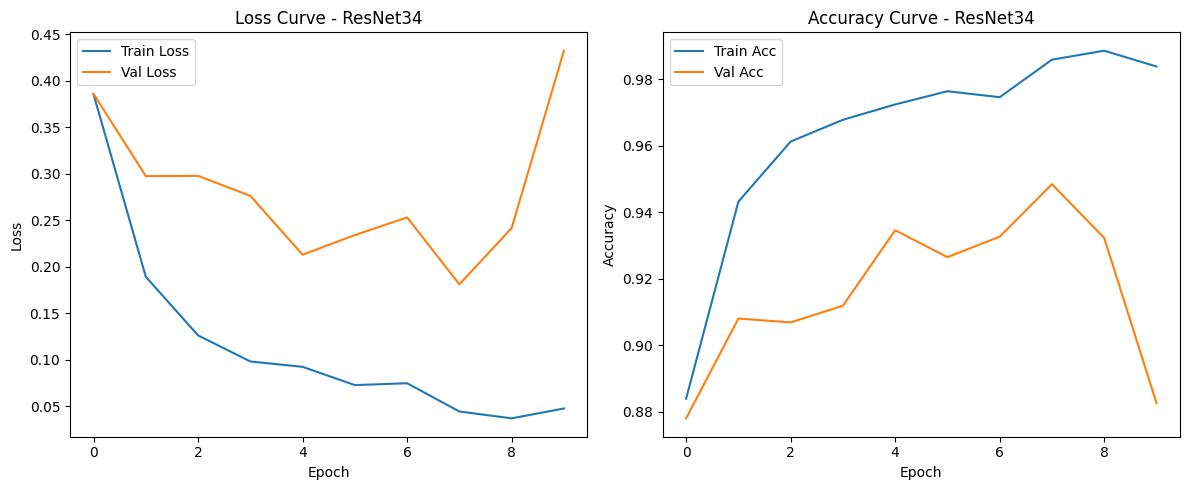

In [41]:
# TODO: 5. Plot the loss and accuracy curves.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet34, label='Train Loss')
plt.plot(val_losses_resnet34, label='Val Loss')
plt.title("Loss Curve - ResNet34")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet34, label='Train Acc')
plt.plot(val_accs_resnet34, label='Val Acc')
plt.title("Accuracy Curve - ResNet34")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [42]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [43]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 10
INIT_LR = 0.001
BATCH_SIZE = 64

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 5.0
LOSS_RATIO = 0.7  # 0.7 * distillation + 0.3 * classification loss


In [45]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
from torchvision import models

resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(torch.unique(labels_train_index)))
resnet18 = resnet18.to(device)


In [47]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet34 = models.resnet34(pretrained=False)
resnet34.fc = nn.Linear(resnet34.fc.in_features, len(torch.unique(labels_train_index)))
resnet34.load_state_dict(torch.load("../models/resnet34_checkpoint.pkl", map_location=device))
resnet34 = resnet34.to(device)
resnet34.eval()  # freeze the teacher model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
# TODO: 4. Define the optimizer, loss function, etc.

optimizer = optim.Adam(resnet18.parameters(), lr=INIT_LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Distillation loss
class DistillationLoss(nn.Module):
    def __init__(self, temperature=5.0, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl = nn.KLDivLoss(reduction='batchmean')
        self.ce = nn.CrossEntropyLoss()

    def forward(self, student_logits, teacher_logits, labels):
        soft_loss = self.kl(
            F.log_softmax(student_logits / self.temperature, dim=1),
            F.softmax(teacher_logits / self.temperature, dim=1)
        ) * (self.temperature ** 2)
        hard_loss = self.ce(student_logits, labels)
        return self.alpha * soft_loss + (1 - self.alpha) * hard_loss

criterion = DistillationLoss(TEMPERATURE, LOSS_RATIO)


In [50]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import os

# Set up device and move models
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
resnet18 = resnet18.to(device)
resnet34 = resnet34.to(device)
resnet34.eval()  # Teacher model always in eval mode

# Distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)
    hard_loss = F.cross_entropy(student_logits, labels)
    return alpha * soft_loss + (1. - alpha) * hard_loss

# DataLoaders (MPS has no pin_memory, so False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False)

# Metric trackers
train_accs_resnet18, train_losses_resnet18 = [], []
val_accs_resnet18, val_losses_resnet18 = [], []

best_val_acc = 0.0

for epoch in range(MAX_EPOCH):
    resnet18.train()
    total_train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            teacher_logits = resnet34(images)

        student_logits = resnet18(images)
        loss = distillation_loss(student_logits, teacher_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        correct_train += (student_logits.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses_resnet18.append(train_loss)
    train_accs_resnet18.append(train_acc)

    # Validation
    resnet18.eval()
    total_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet18(images)
            loss = F.cross_entropy(outputs, labels)

            total_val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses_resnet18.append(val_loss)
    val_accs_resnet18.append(val_acc)

    scheduler.step()
    print(f"Epoch {epoch+1}/{MAX_EPOCH} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs("../models", exist_ok=True)
        torch.save(resnet18.state_dict(), "../models/resnet18_checkpoint.pkl")

print("Student training done. Best Val Acc:", best_val_acc)

Epoch 1/10 - Train Acc: 0.6459, Val Acc: 0.5300
Epoch 2/10 - Train Acc: 0.7100, Val Acc: 0.6546
Epoch 3/10 - Train Acc: 0.7526, Val Acc: 0.6127
Epoch 4/10 - Train Acc: 0.7791, Val Acc: 0.7681
Epoch 5/10 - Train Acc: 0.8359, Val Acc: 0.8158
Epoch 6/10 - Train Acc: 0.8445, Val Acc: 0.8085
Epoch 7/10 - Train Acc: 0.8674, Val Acc: 0.8150
Epoch 8/10 - Train Acc: 0.8742, Val Acc: 0.8154
Epoch 9/10 - Train Acc: 0.8887, Val Acc: 0.8119
Epoch 10/10 - Train Acc: 0.9147, Val Acc: 0.8577
Student training done. Best Val Acc: 0.8576923076923076


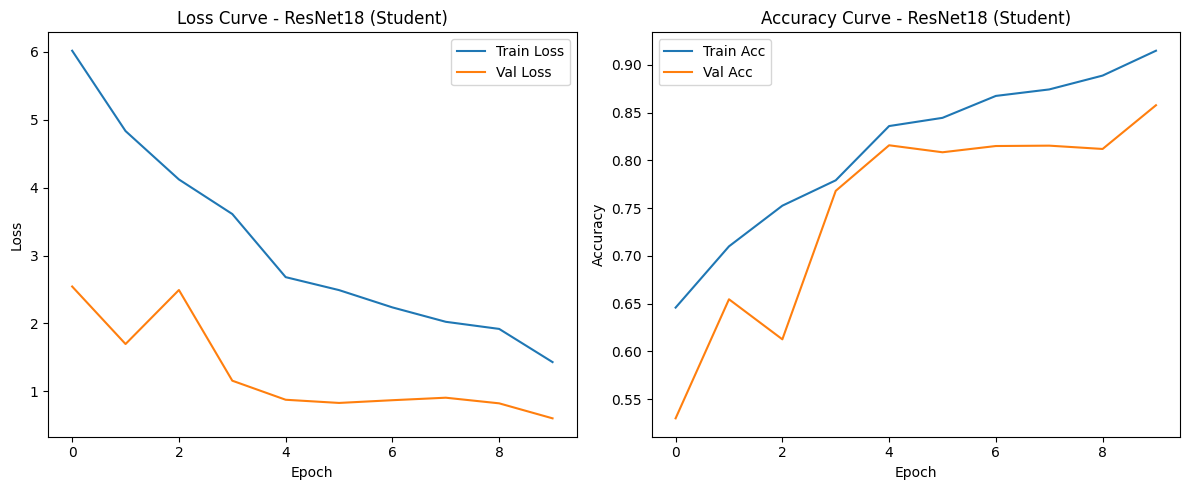

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss')
plt.plot(val_losses_resnet18, label='Val Loss')
plt.title("Loss Curve - ResNet18 (Student)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet18, label='Train Acc')
plt.plot(val_accs_resnet18, label='Val Acc')
plt.title("Accuracy Curve - ResNet18 (Student)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
baseline_resnet18 = torchvision.models.resnet18(num_classes=100)  # Use correct num_classes for CIFAR-100
baseline_resnet18 = baseline_resnet18.to(device)
optimizer_baseline = torch.optim.Adam(baseline_resnet18.parameters(), lr=0.001)
scheduler_baseline = torch.optim.lr_scheduler.StepLR(optimizer_baseline, step_size=5, gamma=0.5)

train_accs_baseline, val_accs_baseline = [], []
best_val_acc_baseline = 0.0

for epoch in range(MAX_EPOCH):
    baseline_resnet18.train()
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = baseline_resnet18(images)
        loss = F.cross_entropy(outputs, labels)

        optimizer_baseline.zero_grad()
        loss.backward()
        optimizer_baseline.step()

        correct_train += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_accs_baseline.append(train_acc)

    # Validation
    baseline_resnet18.eval()
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = baseline_resnet18(images)
            loss = F.cross_entropy(outputs, labels)

            correct_val += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_accs_baseline.append(val_acc)

    scheduler_baseline.step()
    print(f"[Baseline] Epoch {epoch+1}/{MAX_EPOCH} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc_baseline:
        best_val_acc_baseline = val_acc
        torch.save(baseline_resnet18.state_dict(), "../models/resnet18_baseline_checkpoint.pkl")

print("Baseline ResNet18 training done. Best Val Acc:", best_val_acc_baseline)

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [52]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

from torchvision import models

resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(index_to_label))
resnet18.load_state_dict(torch.load("../models/resnet18_checkpoint.pkl", map_location=device))
resnet18 = resnet18.to(device)
resnet18.eval()  # Important: disable dropout & batchnorm updates


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
# TODO: 2. Do prediction using the images in the testing set.
predictions = []

with torch.no_grad():
    for i in range(tensor_test.shape[0]):
        image = tensor_test[i].unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)
        output = resnet18(image)
        _, predicted_idx = torch.max(output, 1)
        predictions.append(predicted_idx.item())



In [55]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...


import pandas as pd
index_to_label = torch.load("../data_preprocessed/index_to_label.pt")

submission_rows = []
for i, pred_idx in enumerate(predictions):
    label = index_to_label[pred_idx]
    filename = f"{i}.jpg"
    submission_rows.append([filename, label])

submission_df = pd.DataFrame(submission_rows, columns=["file_name", "label"])
submission_df.to_csv("submission.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../data_preprocessed/index_to_label.pt'